<a href="https://colab.research.google.com/github/dgambone3/CSC4850-Machine-Learning/blob/main/FDS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
# to import data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# load dataset and drop null column
df = pd.read_csv('speeddating.csv')
df = df.drop(labels=['has_null', 'field', 'wave'], axis=1)

# for col in df:
#   print(col)

df.replace("b\'?\'", np.nan, inplace=True)

### encoding object row values ###
for col in df.columns:   # output old value and encoded value for intrepretation later
  if df[col].dtype == "object":
    # print(col)
    old_values = pd.DataFrame(columns=[]) #dataframe to hold and display values
    encoder = OrdinalEncoder()
    df[col] = encoder.fit_transform(df[[col]]) #fit transform data to encoded data
    # add to df
    old_values['encoded_value'] = pd.DataFrame(df[col].unique())
    old_values['original_value'] = pd.Series(encoder.categories_[0])
    # print('\n   ---',col,'---')
    # print(old_values.sort_values(by=['encoded_value']))


# Preprocessing

In [32]:
# impute null values - dropping all null would significantly reduce dataset size
null = df.isnull().sum() # find amount all null values
print('Data shape before dropping null: ', df.shape)
# print(null)
# drop cols with more than 300 null values
drop_cols = [col for col, null_count in null.items() if null_count > 300]
df = df.drop(columns=drop_cols)

null = df.isnull().sum()
print('Data shape after dropping null: ', df.shape)
# print(null)

# impute null values
for column, null_count in null.items():
  if null_count != 0:
    med = df[column].median()
    df[column].fillna(med, inplace=True)


pre_data = df#.iloc[:, :-1]

#create pca and fit/transform
pca = PCA(n_components=55)
pca.fit(pre_data).transform(pre_data)

pc_components = len(pca.components_)
# get index of hightest variance for each feature/component
most_impt = [np.abs(pca.components_[i]).argmax() for i in range(pc_components)]

init_cols = pre_data.columns
pc_names = [init_cols[most_impt[i]] for i in range(pc_components)]
pc_vals = pca.components_[0]

dic = {'PC{}'.format(i): pc_names[i] for i in range(pc_components)}
final_cols = pd.DataFrame(dic.items())
final_cols['PCA Variance'] = abs(pc_vals[most_impt])
final_cols = final_cols.rename(columns={0:'Principal_Components', 1:'Feature'})\
                              .drop_duplicates(subset='Feature')
                              
# display(final_cols.sort_values(by=['Feature'])) # temp print to display table later
temp_data = pre_data[final_cols['Feature']]



### final dataframe with no nulls, imputed values, and selected features
data = pd.concat([temp_data, df['match']], axis=1) 
print('Final shape of X before beginning analysis: ', data.shape)

Data shape before dropping null:  (8378, 109)
Data shape after dropping null:  (8378, 109)
Final shape of X before beginning analysis:  (8378, 44)


# Exploratory Data Analysis

In [5]:
# X.describe().T

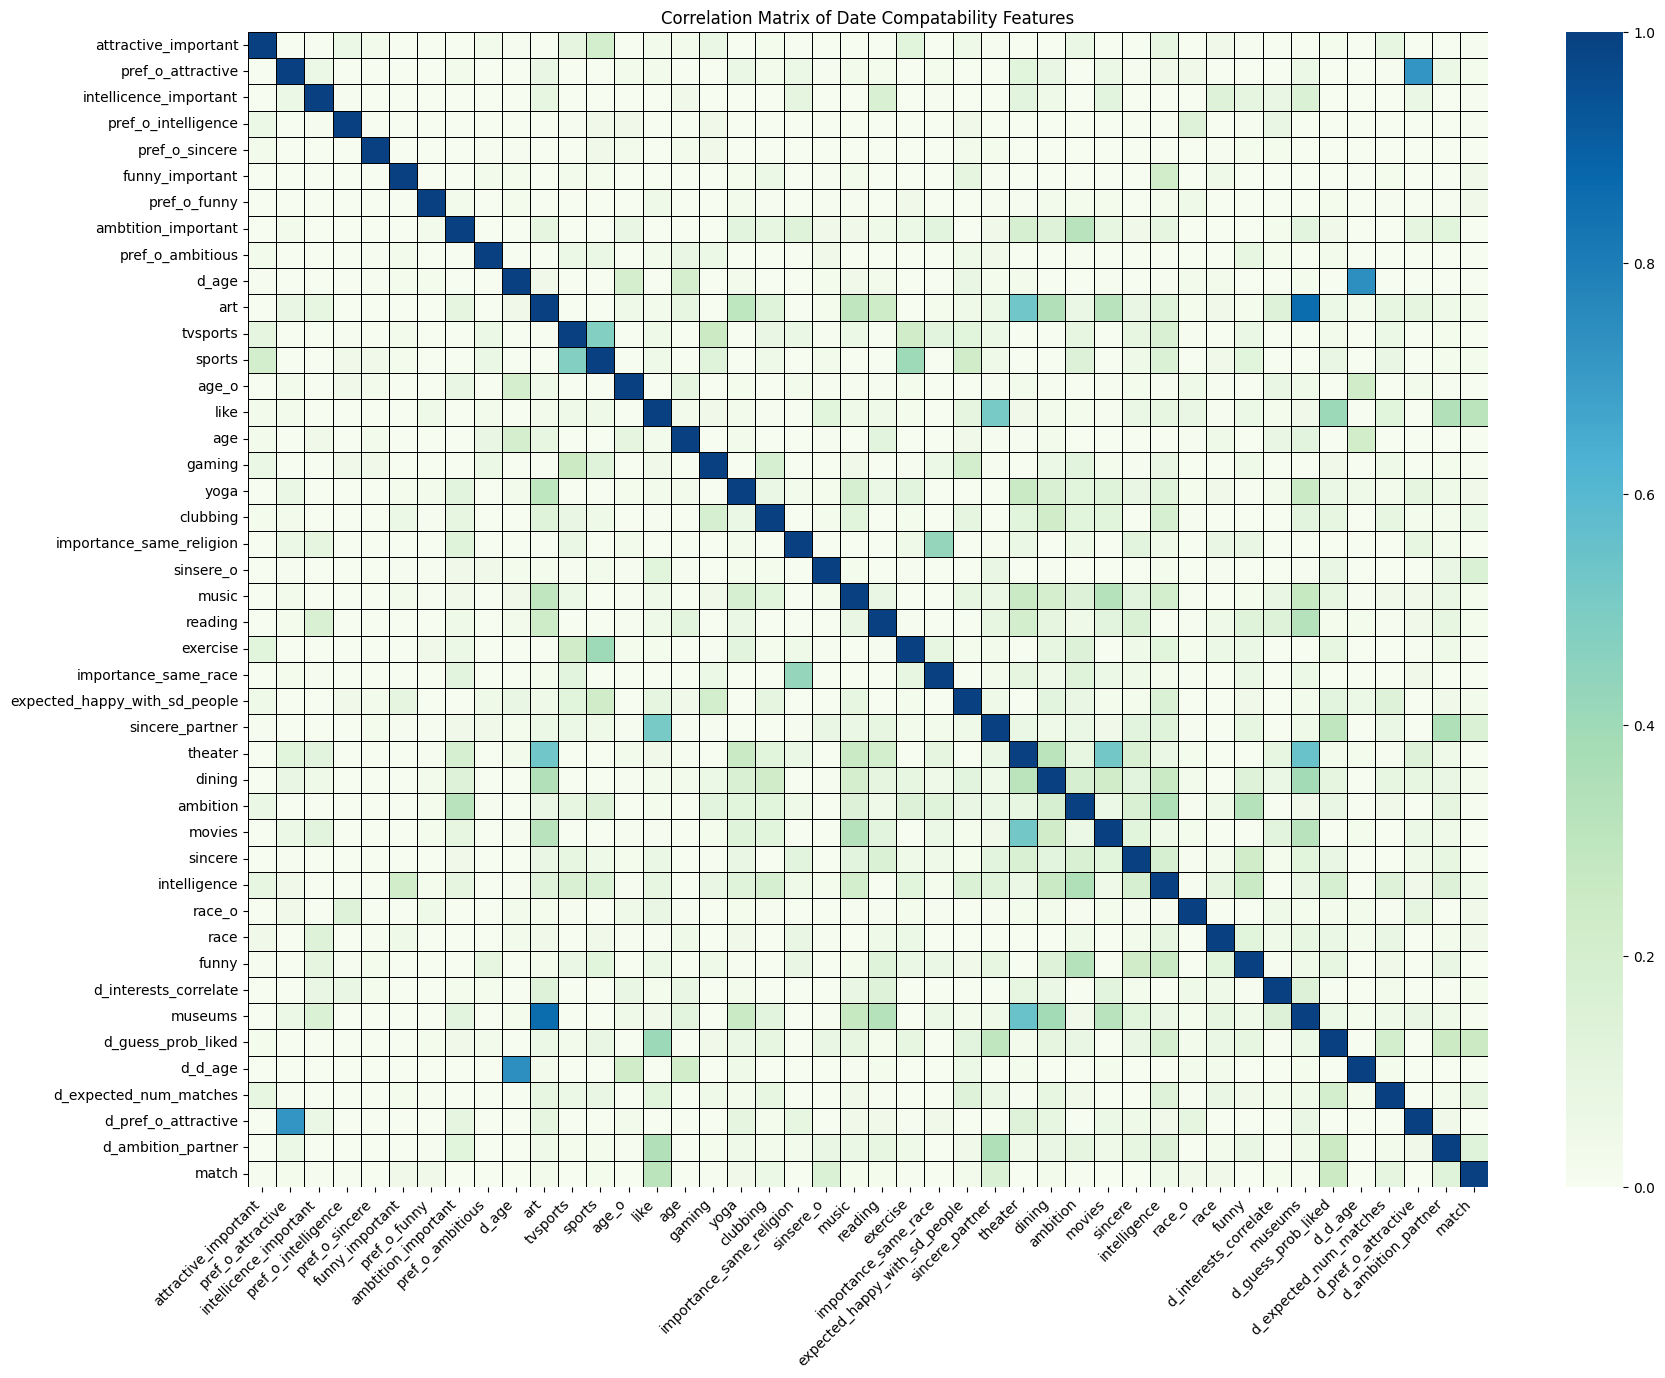

In [33]:
corr = round(data.corr(), 2)
mask = np.triu(np.ones_like(corr, dtype=bool))
fig = plt.figure(figsize=(20,15))
axes = fig.subplots()

sns.heatmap(corr, vmin=0, vmax=1, cmap='GnBu', linewidth=.5, linecolor='black')
plt.xticks(ha='right', rotation=45)
plt.title('Correlation Matrix of Date Compatability Features')
plt.show()


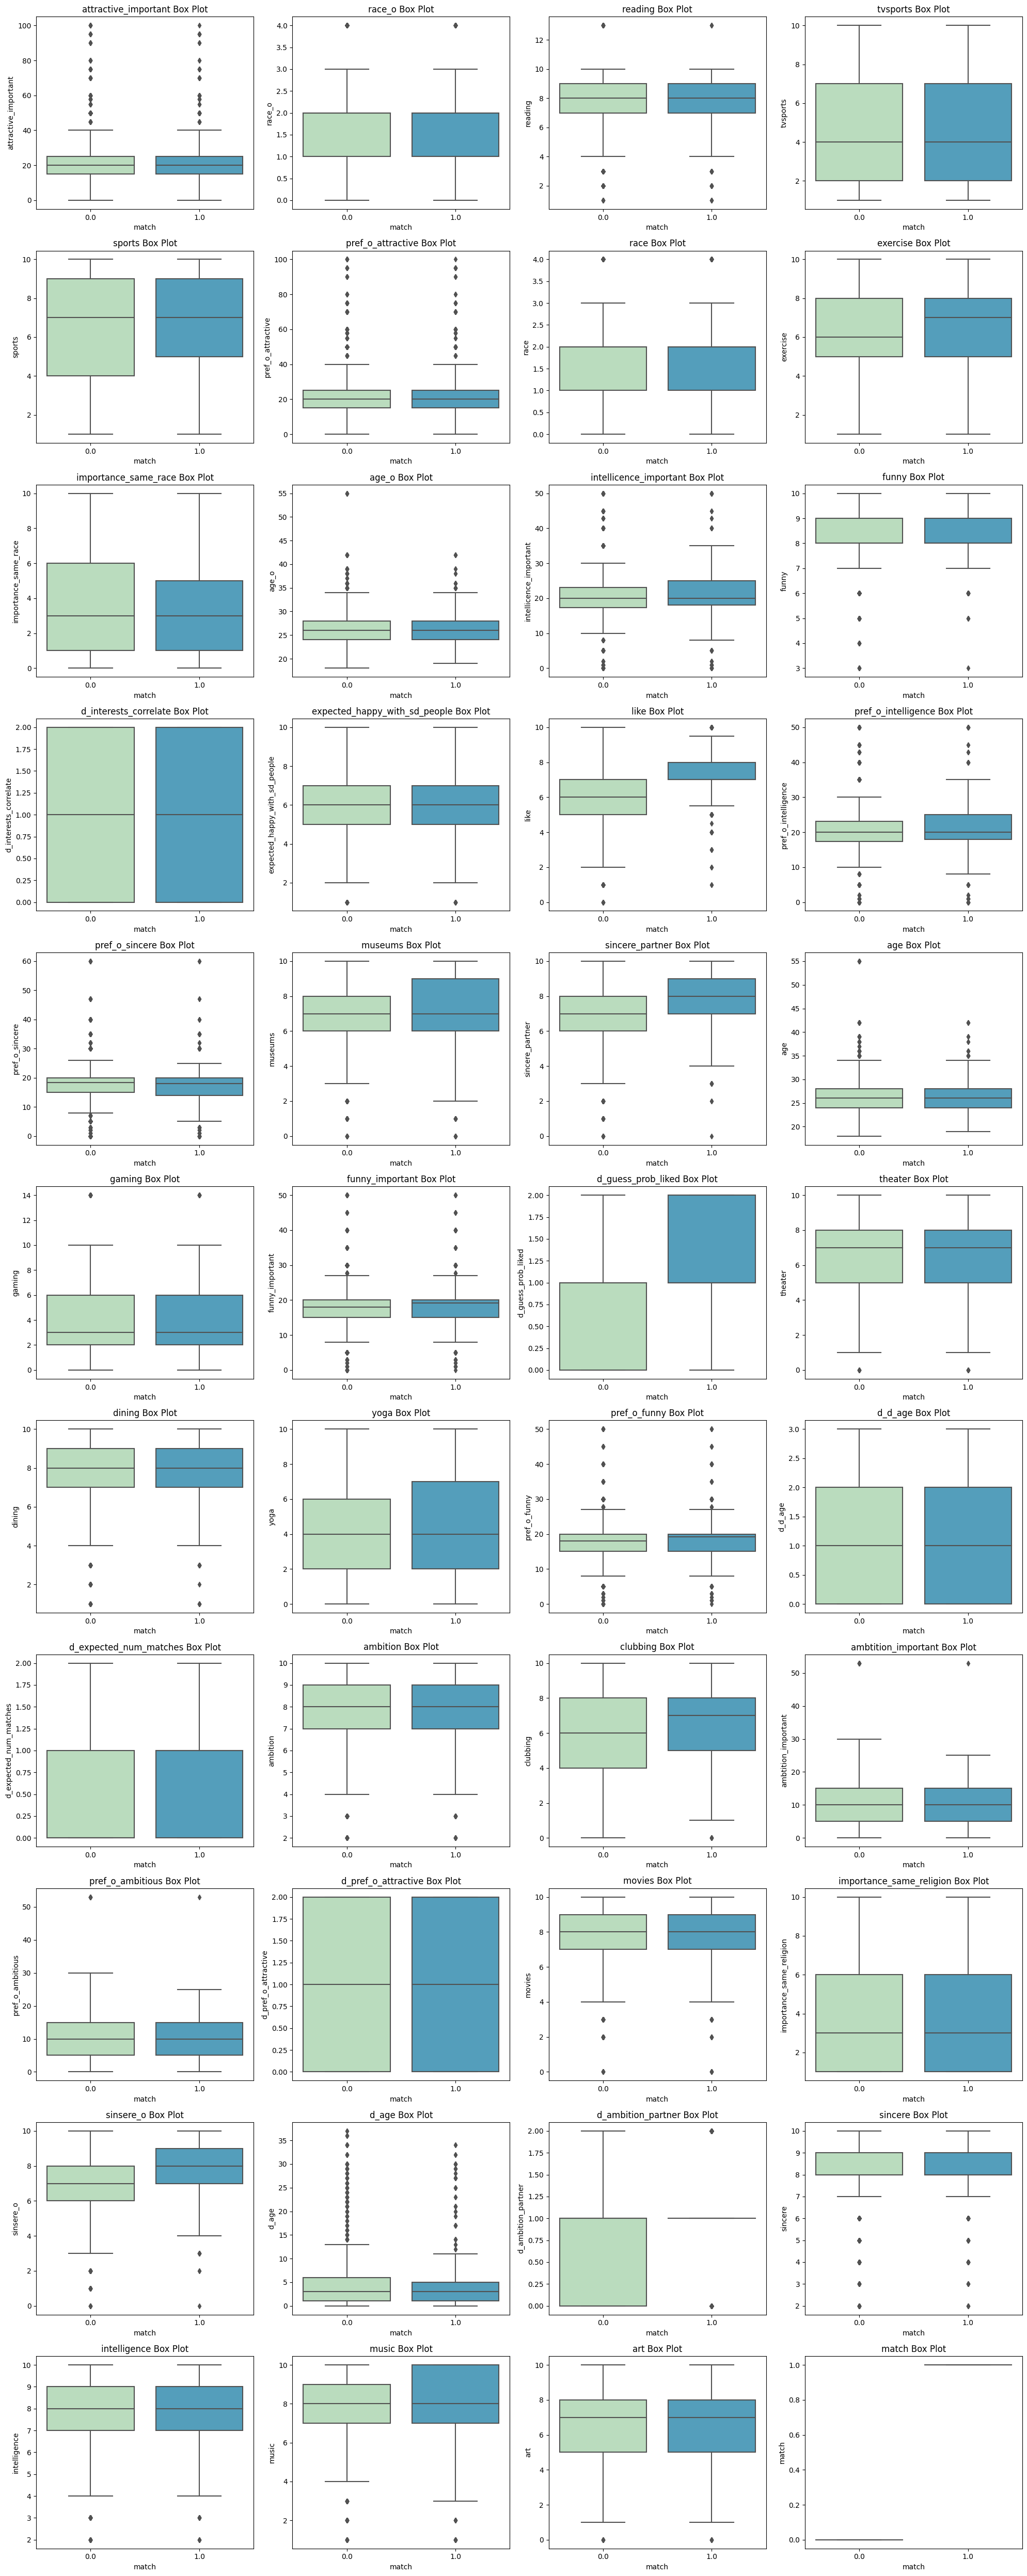

In [38]:
fig = plt.figure(figsize=(20,50)) # W x H
axes = fig.subplots(11,4)
i = 0
j = 0
for col in data:
  sns.boxplot(x=data['match'], 
              y = data[col], 
              data=data, 
              ax=axes[i,j], 
              palette='GnBu')
  axes[i,j].set_title(f'{col} Box Plot')
  i+=1
  j+=1
  if j == 4: j=0
  if i == 11: i=0
fig.tight_layout()
plt.show()

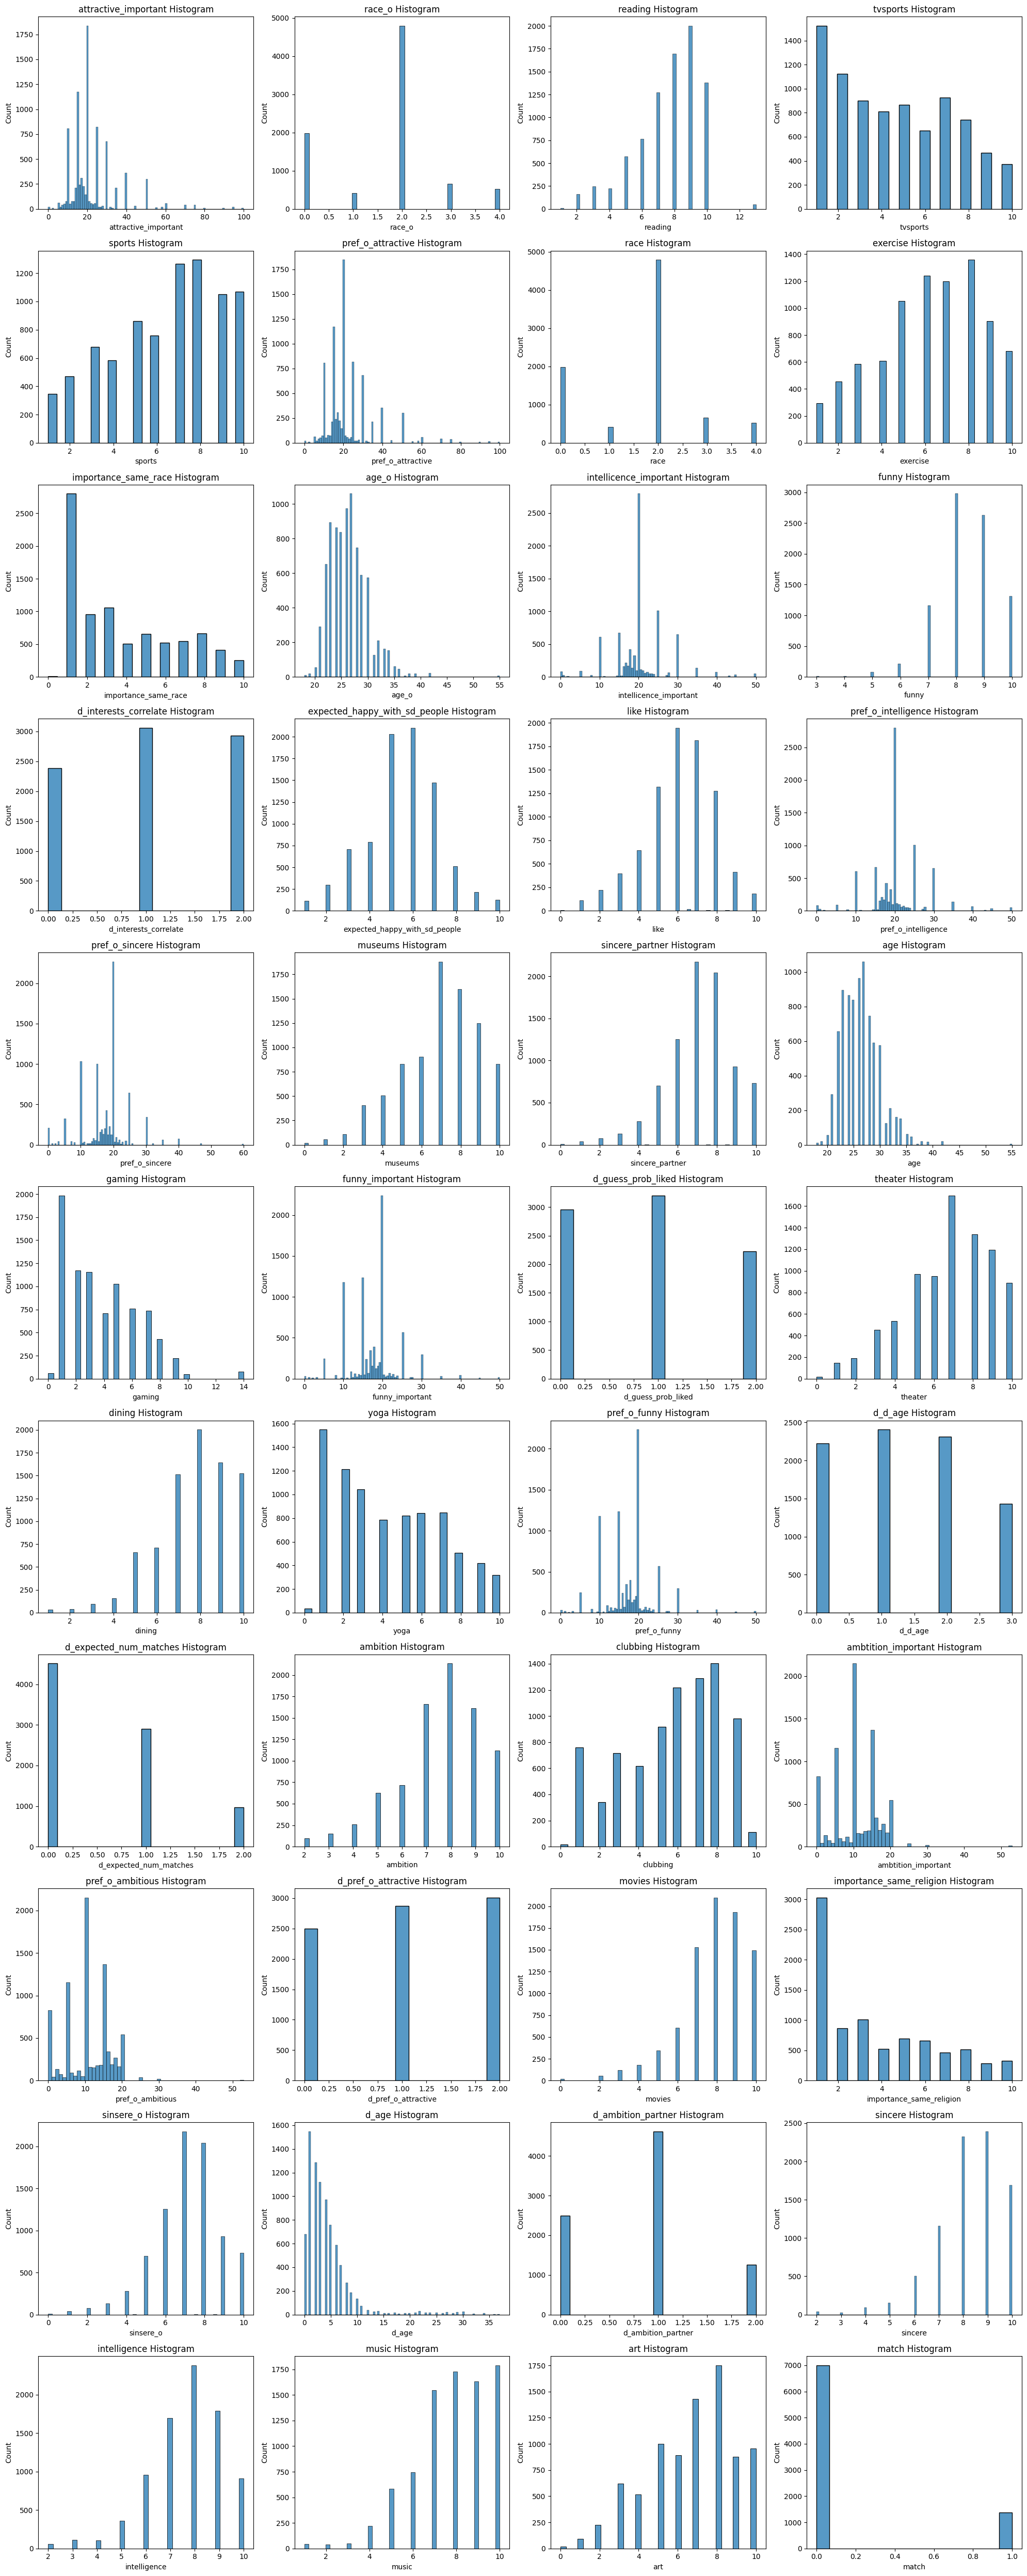

In [44]:
fig = plt.figure(figsize=(20,50)) # W x H
axes = fig.subplots(11,4)
i = 0
j = 0
for col in data:
  sns.histplot(data=data[col], 
              stat='count',
              ax=axes[i,j])
  axes[i,j].set_title(f'{col} Histogram')
  i+=1
  j+=1
  if j == 4: j=0
  if i == 11: i=0
fig.tight_layout()
plt.show()